In [2]:
import pyodbc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import os

In [3]:
# Define the path to your SQL file
sql_file_path = 'get_data.sql'
# Read the SQL query from the file
with open(sql_file_path, 'r') as file:
    SQL = file.read()
connection_string = f"DRIVER=SQL Server;SERVER=CAWPAPP3464;DATABASE=CGC;Trusted_Connection=yes"
connection = pyodbc.connect(connection_string)
cursor = connection.cursor()
cursor.execute(SQL)
rows, columns = cursor.fetchall(), [desc[0] for desc in cursor.description]
df = pd.DataFrame.from_records(data=rows, columns=columns)

In [4]:
print(df.columns) 
print(df.dtypes)

Index(['CF: BUSINESS CHANNEL', 'LINEOFBUSINESS', 'CUSTOMERNAME',
       'LOCATIONNAME', 'ITEMNAME', 'Quantity_2023_01', 'unit_price_2023_01',
       'Quantity_2024_01', 'unit_price_2024_01'],
      dtype='object')
CF: BUSINESS CHANNEL     object
LINEOFBUSINESS           object
CUSTOMERNAME             object
LOCATIONNAME             object
ITEMNAME                 object
Quantity_2023_01          int64
unit_price_2023_01      float64
Quantity_2024_01          int64
unit_price_2024_01      float64
dtype: object


In [5]:
# change column anme
df.rename(columns={"CF: BUSINESS CHANNEL": 'BUSINESS_CHANNLE'},inplace=True)

In [164]:
# split and filter data
# condition_Jan = ((df['Quantity_2023_01']> 0) & (df['Quantity_2024_01']> 0))
# df_jan = df[condition_Jan][['CF: BUSINESS CHANNEL', 'LINEOFBUSINESS', 'CUSTOMERNAME',
#        'LOCATIONNAME', 'ITEMNAME', 'Sales_2023_01', 'Quantity_2023_01',
#        'unit_price_2023_01', 'Sales_2024_01', 'Quantity_2024_01',
#        'unit_price_2024_01']]
# condition_jul = ((df['Quantity_2023_07']> 0) & (df['Quantity_2024_07']> 0))
# df_jul = df[condition_Jan][['CF: BUSINESS CHANNEL', 'LINEOFBUSINESS', 'CUSTOMERNAME',
#        'LOCATIONNAME', 'ITEMNAME', 'Sales_2023_07', 'Quantity_2023_07',
#        'unit_price_2023_07', 'Sales_2024_07', 'Quantity_2024_07',
#        'unit_price_2024_07']]

In [6]:
# quantify changes
df['Change_in_Price'] = (df['unit_price_2024_01'] - df['unit_price_2023_01'])
df['Change_in_Quantity'] = (df['Quantity_2024_01'] - df['Quantity_2023_01'])
df['Change_in_Price_Percentage'] = df['Change_in_Price']/ df['unit_price_2023_01']
df['Change_in_Quantity_Percentage'] = df['Change_in_Quantity']/ df['Quantity_2023_01']

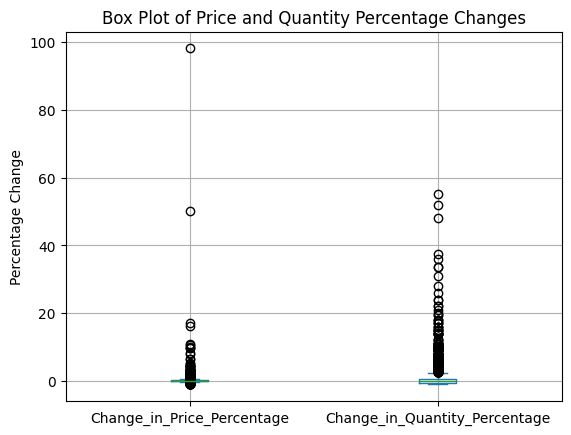

In [7]:
# plot percentage 
df[['Change_in_Price_Percentage', 'Change_in_Quantity_Percentage']].plot(kind='box')
plt.title('Box Plot of Price and Quantity Percentage Changes')
plt.ylabel('Percentage Change')
plt.grid(True)
plt.show()

# remove outliers

In [15]:
# Remove outliers based on change percentage
mean_PED_p = df['Change_in_Price_Percentage'].mean()
std_PED_p = df['Change_in_Price_Percentage'].std()
mean_PED_q = df['Change_in_Quantity_Percentage'].mean()
std_PED_q = df['Change_in_Quantity_Percentage'].std()
outliers = (df['Change_in_Price_Percentage'] < (mean_PED_p - 3 * std_PED_p)) | (df['Change_in_Price_Percentage'] > (mean_PED_p + 3 * std_PED_p)) \
| (df['Change_in_Quantity_Percentage'] < (mean_PED_q - 3 * std_PED_q)) | (df['Change_in_Quantity_Percentage'] > (mean_PED_q + 3 * std_PED_q))
df_filterred = df[~outliers]

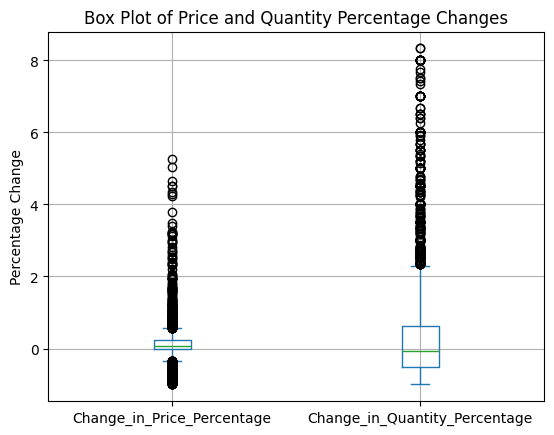

In [16]:
df_filterred[['Change_in_Price_Percentage', 'Change_in_Quantity_Percentage']].plot(kind='box')
plt.title('Box Plot of Price and Quantity Percentage Changes')
plt.ylabel('Percentage Change')
plt.grid(True)
plt.show()

In [27]:
# show some basic stats
df_filterred_stats = df_filterred.groupby('ITEMNAME')['ITEMNAME'].describe().sort_values(by='count', ascending=False)
print(df_filterred_stats.head(10))

                                                   count unique  \
ITEMNAME                                                          
COKE CLASSIC BTL 500ml / Saveur Originale            875      1   
COKE ZERO BTL 500ml / Sans Calories                  712      1   
CANADRY GINGERALE BTL 500ml / Gingembre              699      1   
COKE DIET BTL 500ml / Edulcorant Artificiel          672      1   
NESTEA ORIGL ICED TEA BTL 500ml / The Glace Citron   346      1   
FANTA ORANGE BTL 500ml / Soda A L'Orange             242      1   
EVIAN NATURAL SPRING WATER BTL 500ml / Eau Mineral   174      1   
AHA LIME WATERMLN BTL 500ml / Citron Vert Pasteque   160      1   
SPRITE ORIGINAL BTL 500ml / Regulier                 145      1   
BARQS ORIGINAL ROOT BEER BTL 500ml / Racinette       117      1   
PERRIER MINERAL WATER PLAIN BTL 500ml / Regulier      95      1   
C2 Green Tea Apple 500ml Btl/C2 Thé Vert              51      1   
C2 Green Tea Lemon 500Ml Btl/C2 Thé Vert              44      

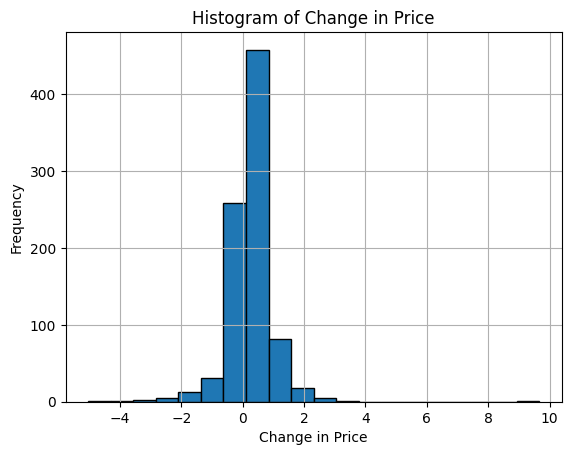

In [32]:
# draw the price chagne distribution fo ITEM: COKE CLASSIC BTL 500ml / Saveur Originale 
df_coke = df_filterred[df_filterred['ITEMNAME'] == 'COKE CLASSIC BTL 500ml / Saveur Originale']
plt.hist(df_coke['Change_in_Price'], bins=20, edgecolor='black')  # Adjust bins as needed
plt.title('Histogram of Change in Price')
plt.xlabel('Change in Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

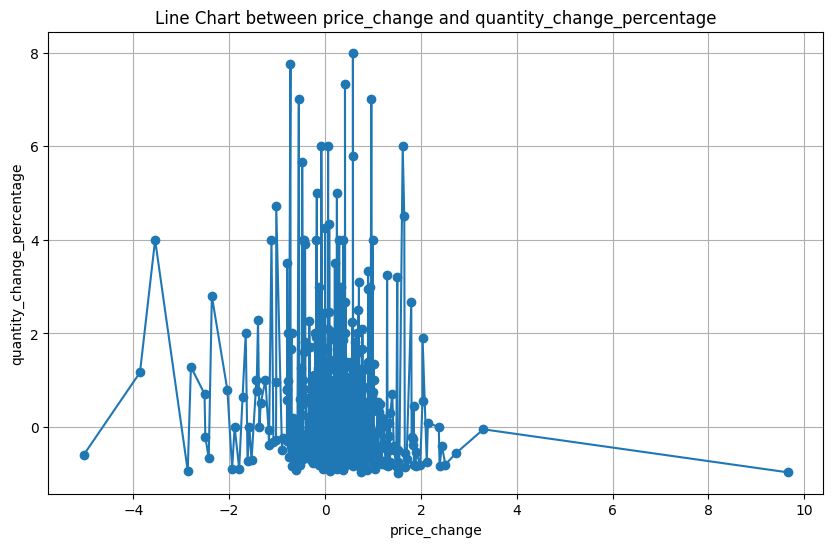

In [37]:
# plot a simple line chart betwwen change in price and change in quantity
plt.figure(figsize=(10, 6))
df_coke_groupby = df_coke.groupby('Change_in_Price')['Change_in_Quantity_Percentage'].mean().reset_index()
plt.plot(df_coke_groupby['Change_in_Price'], df_coke_groupby['Change_in_Quantity_Percentage'], marker='o', linestyle='-')
plt.title('Line Chart between price_change and quantity_change_percentage')
plt.xlabel('price_change')
plt.ylabel('quantity_change_percentage')
plt.grid(True)
plt.show()

In [38]:
# remove outliers based on single items
mean_PED_p = df_coke['Change_in_Price_Percentage'].mean()
std_PED_p = df_coke['Change_in_Price_Percentage'].std()
mean_PED_q = df_coke['Change_in_Quantity_Percentage'].mean()
std_PED_q = df_coke['Change_in_Quantity_Percentage'].std()
outliers = (df_coke['Change_in_Price_Percentage'] < (mean_PED_p - 3 * std_PED_p)) | (df_coke['Change_in_Price_Percentage'] > (mean_PED_p + 3 * std_PED_p)) \
| (df_coke['Change_in_Quantity_Percentage'] < (mean_PED_q - 3 * std_PED_q)) | (df_coke['Change_in_Quantity_Percentage'] > (mean_PED_q + 3 * std_PED_q))
df_coke_filterred = df_coke[~outliers]

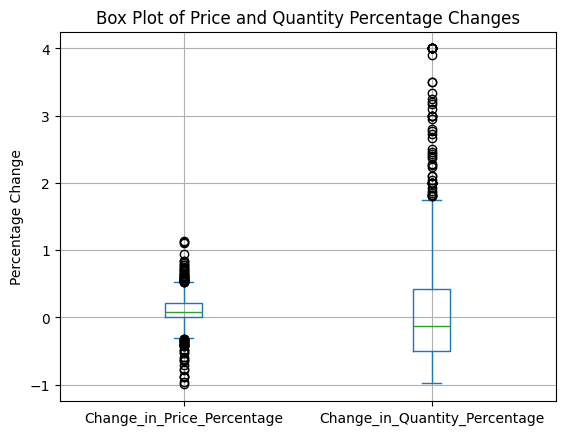

In [39]:
# draw the line chart of singel item
df_coke_filterred[['Change_in_Price_Percentage', 'Change_in_Quantity_Percentage']].plot(kind='box')
plt.title('Box Plot of Price and Quantity Percentage Changes')
plt.ylabel('Percentage Change')
plt.grid(True)
plt.show()

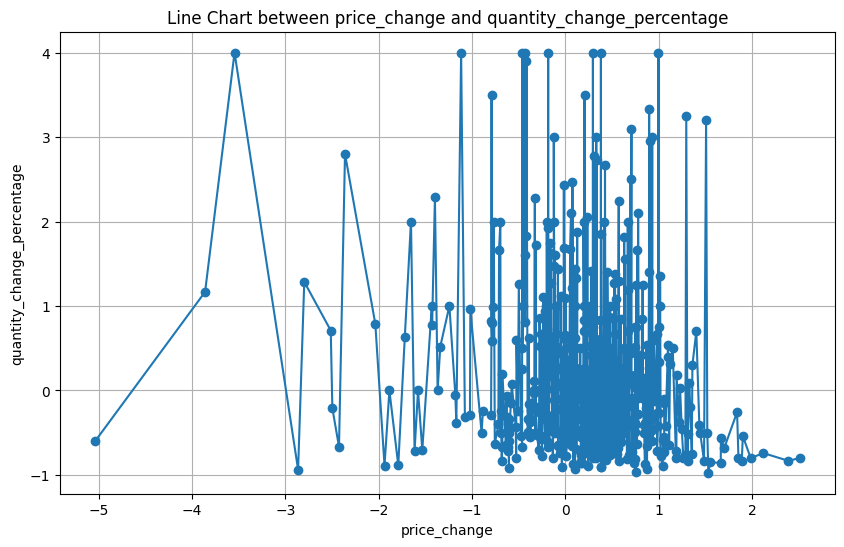

In [42]:
plt.figure(figsize=(10, 6))
df_coke_filterred_groupby = df_coke_filterred.groupby('Change_in_Price')['Change_in_Quantity_Percentage'].mean().reset_index()
plt.plot(df_coke_filterred_groupby['Change_in_Price'], df_coke_filterred_groupby['Change_in_Quantity_Percentage'], marker='o', linestyle='-')
plt.title('Line Chart between price_change and quantity_change_percentage')
plt.xlabel('price_change')
plt.ylabel('quantity_change_percentage')
plt.grid(True)
plt.show()

# remove outliers based on ITEM

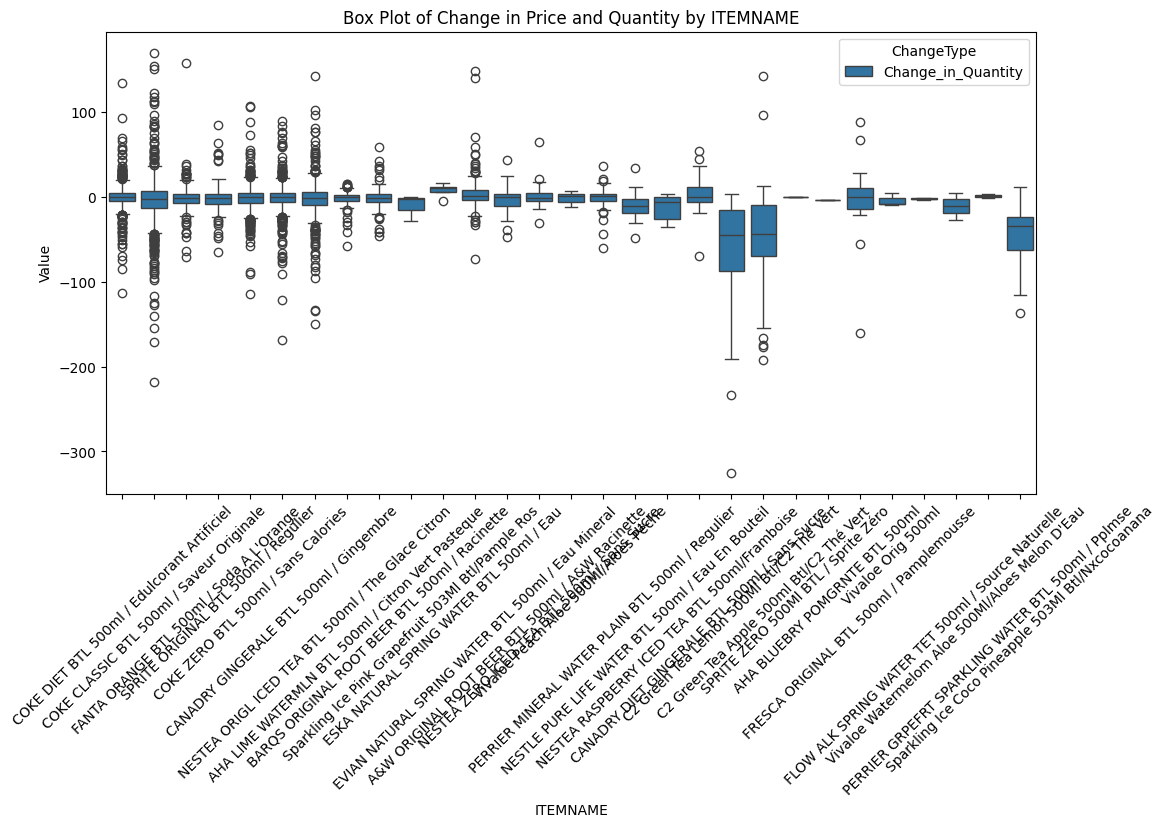

In [46]:
# Melt the DataFrame
df_filterred_melted = df_filterred.melt(id_vars='ITEMNAME', value_vars=['Change_in_Price', 'Change_in_Quantity'], 
                    var_name='ChangeType', value_name='Value')

# Plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='ITEMNAME', y='Value', hue='ChangeType', data=df_filterred_melted)
plt.title('Box Plot of Change in Price and Quantity by ITEMNAME')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if necessary
plt.show()

In [65]:
df_filterred_groupby = df_filterred.groupby('ITEMNAME')
group_mean_p = df_filterred_groupby['Change_in_Price'].transform('mean')
group_std_p = df_filterred_groupby['Change_in_Price'].transform('std')
group_mean_q = df_filterred_groupby['Change_in_Quantity'].transform('mean')
group_std_q = df_filterred_groupby['Change_in_Quantity'].transform('std')
# Step 2: Define the outlier condition for each group
outliers = ((df_filterred['Change_in_Price'] < (group_mean_p - 3 * group_std_p)) | \
            (df_filterred['Change_in_Price'] > (group_mean_p + 3 * group_std_p)) | \
            (df_filterred['Change_in_Quantity'] > (group_mean_q + 3 * group_std_q)) | \
            (df_filterred['Change_in_Quantity'] > (group_mean_q + 3 * group_std_q)))
# # Step 3: Filter out the outliers
df_filterred_filtered = df_filterred[~outliers]

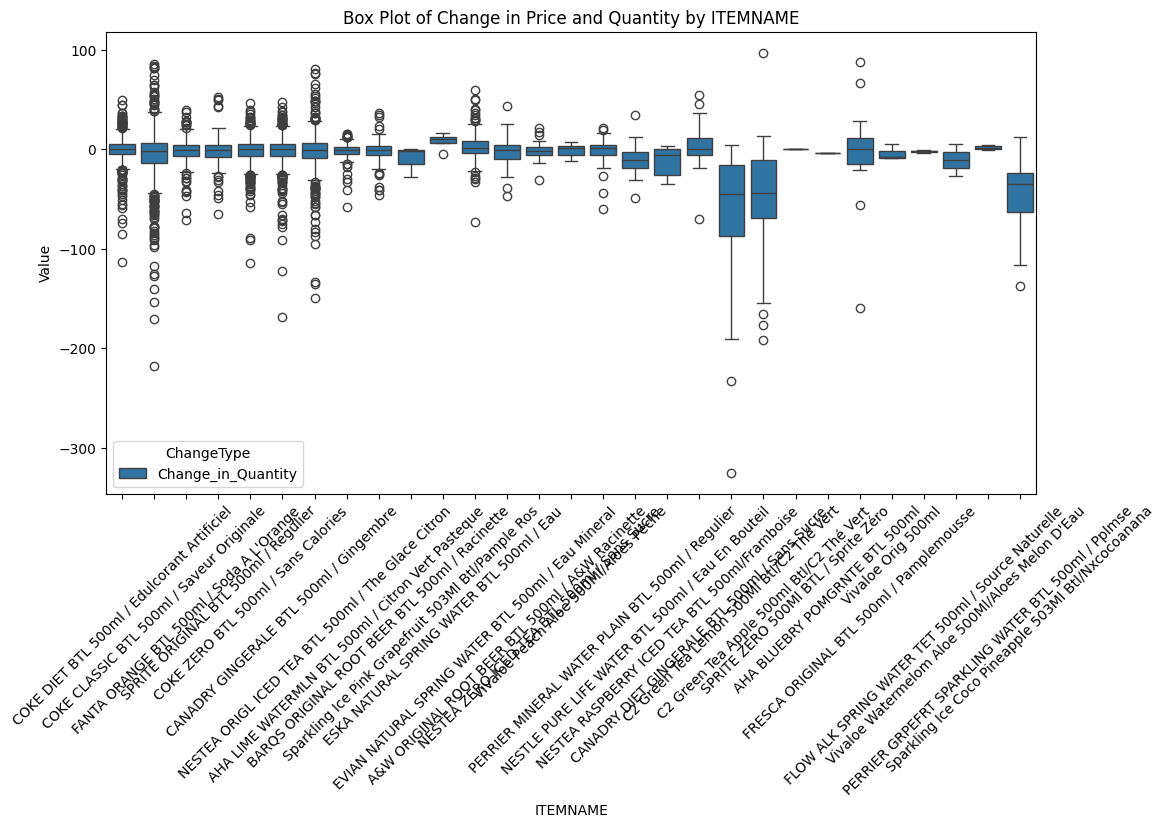

In [67]:
# Melt the DataFrame
# 'Change_in_Price', 'Change_in_Quantity'
df_filterred_melted = df_filterred_filtered.melt(id_vars='ITEMNAME', value_vars=[ 'Change_in_Quantity'], 
                    var_name='ChangeType', value_name='Value')

# Plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='ITEMNAME', y='Value', hue='ChangeType', data=df_filterred_melted)
plt.title('Box Plot of Change in Price and Quantity by ITEMNAME')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if necessary
plt.show()

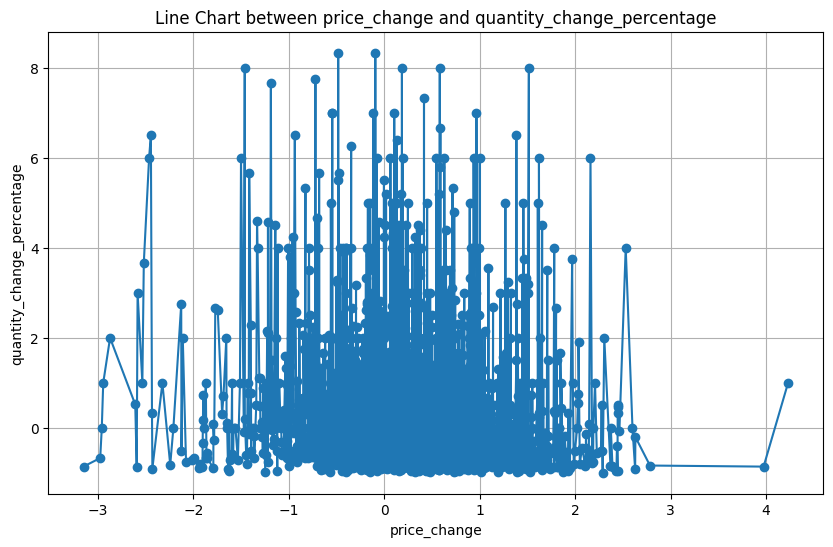

In [71]:
# see the overall pattern between price change and quantity chagne percentage
plt.figure(figsize=(10, 6))
df_filterred_filtered_groupby = df_filterred_filtered.groupby('Change_in_Price')['Change_in_Quantity_Percentage'].mean().reset_index()
plt.plot(df_filterred_filtered_groupby['Change_in_Price'], df_filterred_filtered_groupby['Change_in_Quantity_Percentage'], marker='o', linestyle='-')
plt.title('Line Chart between price_change and quantity_change_percentage')
plt.xlabel('price_change')
plt.ylabel('quantity_change_percentage')
plt.grid(True)
plt.show()

In [ ]:
df_jan_groupby = df.groupby('price_change')[['Quantity_2023_01', 'Quantity_2024_01']].sum().reset_index()
df_jan_groupby['quantity_change_percentage'] = (df_jan_groupby['Quantity_2024_01']-df_jan_groupby['Quantity_2023_01'])/df_jan_groupby['Quantity_2023_01']

In [27]:
df_jan_groupby = df_jan_groupby.astype({'price_change': float})

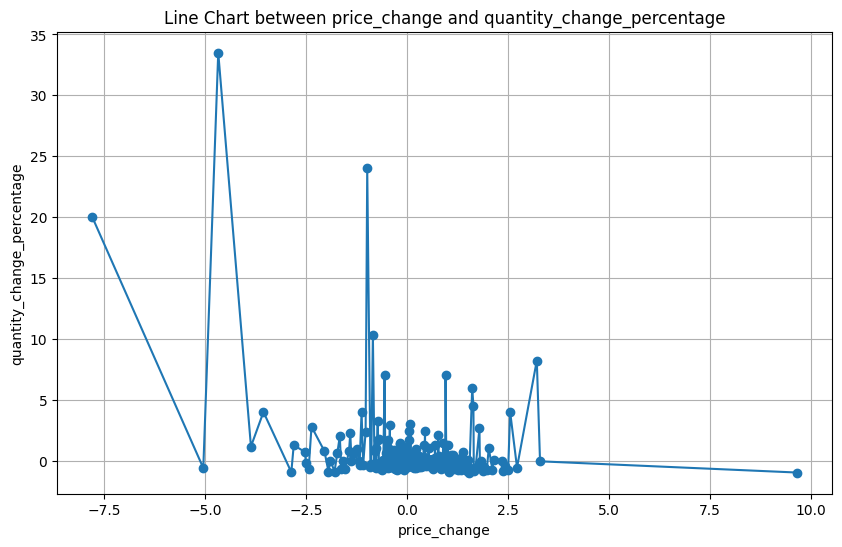

In [28]:
basic_stats = df_jan_groupby['price_change'].describe()
print(basic_stats)

count    247.000000
mean       0.192632
std        1.436759
min       -7.790000
25%       -0.405000
50%        0.270000
75%        0.895000
max        9.660000
Name: price_change, dtype: float64


In [30]:
df_jan_groupby = df_jan_groupby.rename(columns={'price_change': 'Change_in_Price'})

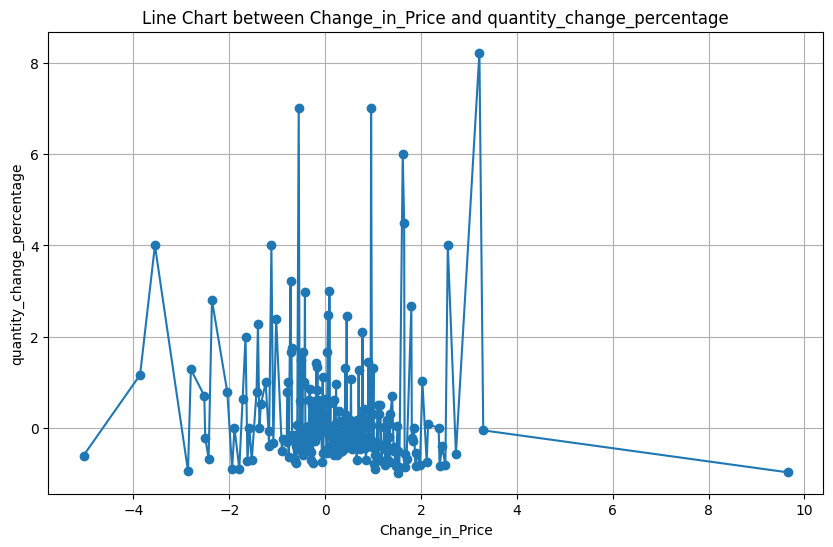

In [35]:
plt.figure(figsize=(10, 6))
plt.plot(df_jan_groupby_nooutliers['Change_in_Price'], df_jan_groupby_nooutliers['quantity_change_percentage'], marker='o', linestyle='-')
plt.title('Line Chart between Change_in_Price and quantity_change_percentage')
plt.xlabel('Change_in_Price')
plt.ylabel('quantity_change_percentage')
plt.grid(True)
plt.show()

In [144]:
# calculate PED
df_jan['Change_in_Price'] = (df_jan['unit_price_2024_01'] - df_jan['unit_price_2023_01'])/df_jan['unit_price_2023_01']
df_jan['Change_in_Quantity'] = (df_jan['Quantity_2024_01'] - df_jan['Quantity_2023_01'])/df_jan['Quantity_2023_01']
df_jan['PED'] = df_jan.apply(lambda row: 0 if row['Change_in_Price'] == 0 else row['Change_in_Quantity']/row['Change_in_Price'], axis=1)

df_jul['Change_in_Price'] = (df_jul['unit_price_2024_07'] - df_jul['unit_price_2023_07'])/df_jul['unit_price_2023_07']
df_jul['Change_in_Quantity'] = (df_jul['Quantity_2024_07'] - df_jul['Quantity_2023_07'])/df_jul['Quantity_2023_07']
df_jul['PED'] = df_jul.apply(lambda row: 0 if row['Change_in_Price'] == 0 else row['Change_in_Quantity']/row['Change_in_Price'], axis=1)

df_jan_PED = df_jan[['CF: BUSINESS CHANNEL', 'LINEOFBUSINESS', 'CUSTOMERNAME','LOCATIONNAME', 'ITEMNAME', 'Change_in_Price','Change_in_Quantity','PED']]
df_jul_PED = df_jul[['CF: BUSINESS CHANNEL', 'LINEOFBUSINESS', 'CUSTOMERNAME','LOCATIONNAME', 'ITEMNAME', 'Change_in_Price','Change_in_Quantity','PED']]

# Below start experimenting on Jan Data

In [145]:
df = df_jan_PED.copy()

In [146]:
# basic stats
basic_stats = df['PED'].describe()
print(basic_stats)

count     4604.000000
mean        -6.930642
std        472.359744
min     -31763.809524
25%         -0.253620
50%          0.790271
75%          1.712537
max        770.929265
Name: PED, dtype: float64


In [147]:
# how much items don't have a pricing change
(df['PED']==0).sum()

303

In [148]:
# remove outliar based on 3 std
mean_PED = df['PED'].mean()
std_PED = df['PED'].std()
outliers = (df['PED'] < (mean_PED - 3 * std_PED)) | (df['PED'] > (mean_PED + 3 * std_PED))
# Filter out outliers
df = df[~outliers]

In [149]:
basic_stats = df['PED'].describe()
print(basic_stats)

count    4601.000000
mean        1.054530
std        29.783091
min      -891.472917
25%        -0.246483
50%         0.791591
75%         1.713661
max       770.929265
Name: PED, dtype: float64


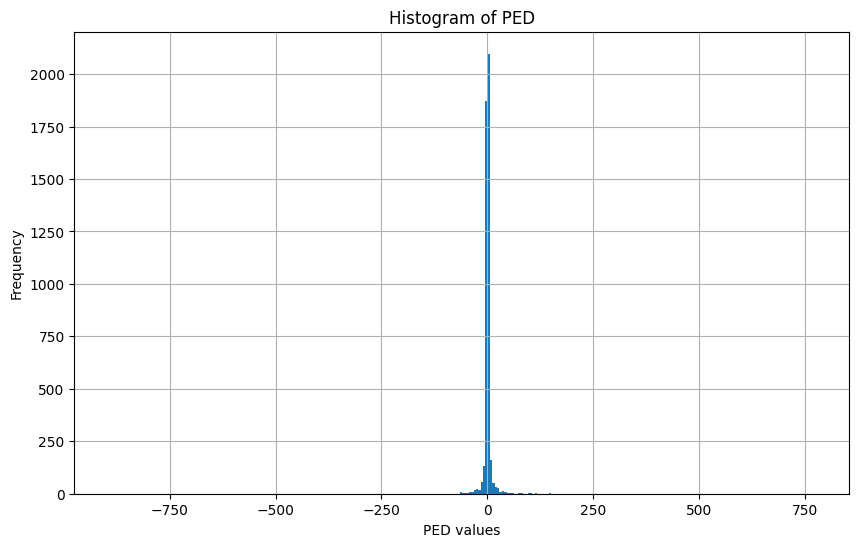

In [130]:
# draw the new distribution
plt.figure(figsize=(10, 6))  # Optional: Adjusts the size of the figure
df['PED'].hist(bins=300)  # Adjust 'bins' as necessary to get a clearer picture
plt.title('Histogram of PED')
plt.xlabel('PED values')
plt.ylabel('Frequency')
plt.show()

# analyze pattern between business channel and PED

In [151]:
# filter out null in business channle
df_Business_Channel = df.dropna(subset=['CF: BUSINESS CHANNEL'])

                                                   count       mean  \
CF: BUSINESS CHANNEL                                                  
HIGHER EDUCATION - COLLEGES / UNIVERSITIES         513.0  -0.407886   
AMUSEMENT / FAMILY ENTERTAINMENT / SPORTS CENTERS  452.0   1.930826   
DISTRIBUTION CENTERS                               430.0   0.746624   
RETAIL STORE - BLUE COLLAR                         290.0   2.003357   
OFFICE PROFESSIONAL - LAW / CORPORATE / HIGH TECH  277.0   1.070559   
HEALTHCARE / HOSPITALS                             231.0   0.728124   
MANUFACTURING FOOD PROCESSING / PRODUCTION         210.0   1.534414   
MANUFACTURING BUILDING / CONSTRUCTION              201.0   3.031371   
MANUFACTURING CONSUMER GOODS                       199.0   4.149741   
RETAIL STORE - WHITE COLLAR                        183.0   4.432224   
SCHOOL 9-12                                        167.0   1.373153   
MOTEL / HOTEL                                      144.0  -8.826476   
UTILIT

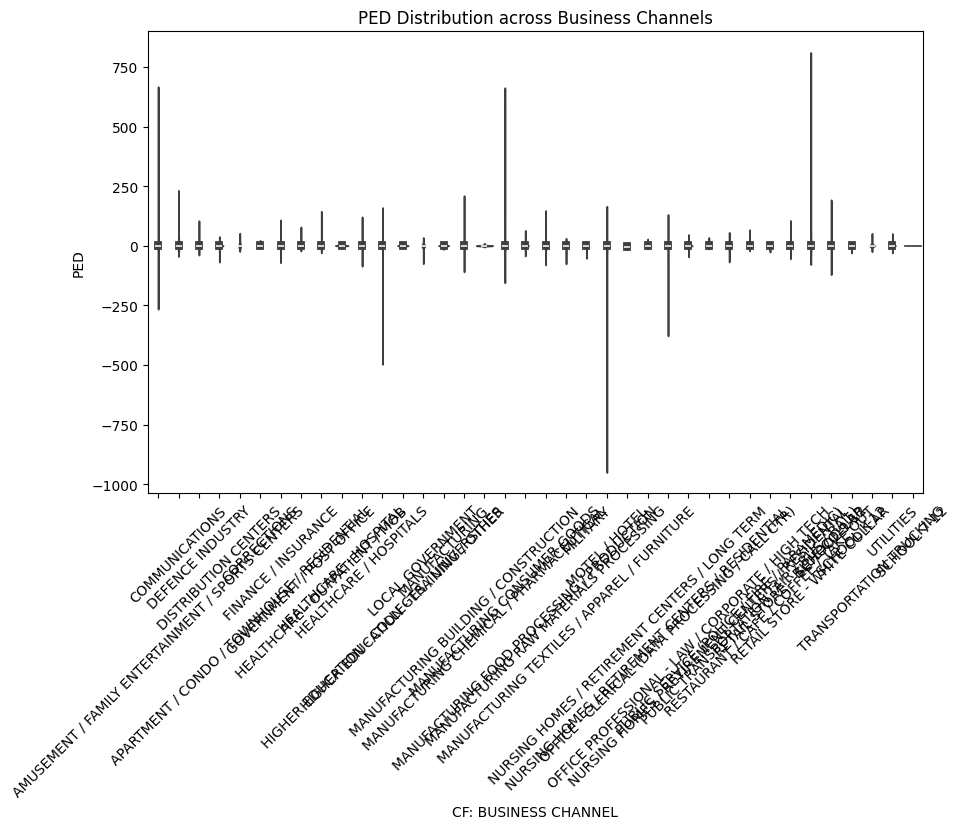

In [ ]:
# chagne column name

In [160]:
# ANOVA


model = ols('PED ~ C(Business_Channel) + C(LINEOFBUSINESS) + C(ITEMNAME) + C(CUSTOMERNAME)', data=df_Business_Channel).fit()

# Conduct ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)

print(anova_table)

C:\Users\Min.Wen\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 37, but rank is 1
  warnings.warn('covariance of constraints does not have full '
C:\Users\Min.Wen\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 29, but rank is 1
  warnings.warn('covariance of constraints does not have full '


                           sum_sq      df         F    PR(>F)
C(Business_Channel)  6.917498e+02    37.0  0.021553  0.883291
C(LINEOFBUSINESS)    1.667888e+02     1.0  0.192275  0.661056
C(ITEMNAME)          5.421823e+02    29.0  0.021553  0.883291
C(CUSTOMERNAME)      1.163754e+04   622.0  0.021569  0.883248
Residual             3.203493e+06  3693.0       NaN       NaN


C:\Users\Min.Wen\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 622, but rank is 1
  warnings.warn('covariance of constraints does not have full '


The ANOVA results indicate that "Business_Channel" does not have a statistically significant effect on the dependent variable in the dataset. The majority of the variation is captured by the within-group variance, as shown in the "Residual" row, suggesting that factors other than "Business_Channel" might be responsible for the observed variations in the dependent variable.

In [156]:
df.columns

Index(['CF: BUSINESS CHANNEL', 'LINEOFBUSINESS', 'CUSTOMERNAME',
       'LOCATIONNAME', 'ITEMNAME', 'Change_in_Price', 'Change_in_Quantity',
       'PED'],
      dtype='object')

In [157]:
# Adding a new column to indicate the price change group based on PED values
df['PriceChangeGroup'] = np.where(df['PED'] == 0, 'Without Price Change', 'With Price Change')
model = ols('Change_in_Quantity ~ C(PriceChangeGroup)', data=df).fit()
# Conduct ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)

print(anova_table)

                           sum_sq      df         F    PR(>F)
C(PriceChangeGroup)     56.226466     1.0  7.376238  0.006634
Residual             35056.556940  4599.0       NaN       NaN


The ANOVA results suggest that the "PriceChangeGroup" has a statistically significant effect on the dependent variable, as indicated by the low p-value and the meaningful F-statistic. This means that the means of the dependent variable for the two price change groups are significantly different from each other, and this difference is unlikely to have occurred by chance. However, most of the variation in the dependent variable is still captured by the residual, indicating other factors not included in this analysis may also be influencing the dependent variable.

## Apply regression analysis to study the price-demand relationship